In [1]:
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.core.display import HTML

%matplotlib inline

## a) Problems definition

In [99]:
# G : R^2 -> Infinite dimensions -> R^4, linear

import fenics as fe

def make_source_term(sources):
    code = "w*exp(-pow(x[0] - p, 2)/0.001)"
    f = fe.Constant(0)
    for (weight, position) in sources:
        f += fe.Expression(code, degree=1, p=position, w=weight)
    return f

def solve_heat_eq(sources):
    level = 25
    mesh = fe.UnitIntervalMesh.create(level)

    V = fe.FunctionSpace(mesh, 'P', 1)

    def boundary(x, on_boundary):
        return on_boundary

    bc = fe.DirichletBC(V, fe.Constant(0), boundary)

    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    f = make_source_term(sources)

    a = fe.dot(fe.grad(u), fe.grad(v)) * fe.dx
    L = f * v * fe.dx

    u = fe.Function(V)
    fe.solve(a == L, u, bc)

    return u

positions = np.array([0.15, 0.85])
real_weights = np.array([0.5, -0.5])
sources = zip(real_weights, positions)

def G(u):
    res = np.zeros((u.shape[0],data_dims))
    for i in range(u.shape[0]):
        u_ = solve_heat_eq(zip(u[i,:], positions))
        res[i,:] = [u_(x) for x in measurement_points]
    return res

particles = 5
state_dims = 2
measurement_points = np.array([0.1, 0.3, 0.7, 0.9])
data_dims = len(measurement_points)

u_real = real_weights.reshape((1,state_dims))

sigma = 0.00075
y = G(u_real).reshape(data_dims) + np.random.normal(scale=sigma, size=data_dims)

In [65]:
# Linear system of equations, finite dimensional

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

A = rot(np.pi/3)

def G(u):
    res = np.zeros((u.shape[0],data_dims))
    for i in range(u.shape[0]):
        res[i,:] = A.dot(u[i,:])
    return res

particles = 5
state_dims = 2
data_dims = 2

u_real = np.array([[1, 1]])

sigma=0.01
y = G(u_real).reshape(data_dims) + np.random.normal(loc=0, scale=sigma, size=2)

## b) Continuous time limit

In [ ]:
def mean_kro(x, y):
    C = np.zeros((x.shape[1], y.shape[1]))
    for i in range(x.shape[0]):
        C += x[i:i+1,:].T.dot(y[i:i+1,:])
    return C/x.shape[0]

In [100]:
from scipy.integrate import ode

def rhs(t, u):
    u = u.reshape((particles,state_dims))
    du = np.zeros_like(u)
    
    p = G(u)
    
    p_bar = np.average(p, axis=0).reshape((1,data_dims))
    u_bar = np.average(u, axis=0).reshape((1,state_dims))
        
    C_up = mean_kro(u - u_bar, p - p_bar)/sigma
    
    for j in range(u.shape[0]):
        du[j,:] = C_up.dot(y - p[j,:]).reshape(state_dims)
    
    return du.reshape(particles*state_dims)

t1=100000
dt=50

u=np.random.normal(size=particles*state_dims).reshape((particles,state_dims))
path = np.zeros((int(t1/dt), u.shape[0], u.shape[1]))

r=ode(rhs).set_integrator('dopri5')
r.set_initial_value(u.reshape(particles*state_dims), 0)

i=0
while i < int(t1/dt):
    r.integrate(r.t+dt)
    u = r.y.reshape((particles,state_dims))
    path[i,:,:] = u
    i += 1

In [89]:
def compute_running_stats(path):
    u_bars = path.mean(axis=1)
    e = np.zeros(path.shape[0])
    r = np.zeros(path.shape[0])

    for i in range(path.shape[0]):
        e[i] = np.linalg.norm(path[i,:,:] - u_bars[i],2, axis=1).mean()
        r[i] = np.linalg.norm(path[i,:,:] - u_real[0,:],2, axis=1).mean()
    
    return e,r

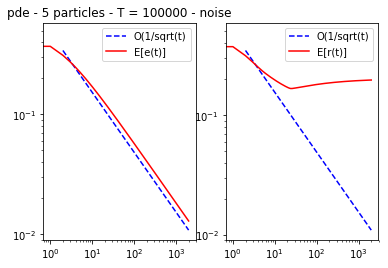

In [107]:
# np.save('pde__5_particles__T_100000__no_noise', path)
path = np.load('pde__5_particles__T_100000__with_noise.npy')
e, r = compute_running_stats(path)

plt.subplot(121)
plt.title('pde - 5 particles - T = 100000 - noise')
x=np.array(range(2,2000))
plt.loglog(x,e[0]/x**0.5, 'b--', label="O(1/sqrt(t)")
plt.loglog(e, c='r', label="E[e(t)]")
plt.legend()

plt.subplot(122)
x=np.array(range(2,2000))
plt.loglog(x,r[0]/x**0.5, 'b--', label="O(1/sqrt(t)")
plt.loglog(r, c='r', label="E[r(t)]")
plt.legend()

## b) EnKF solution

In [3]:
def mean_kro(x, y):
    C = np.zeros((x.shape[1], y.shape[1]))
    for i in range(x.shape[0]):
        C += x[i:i+1,:].T.dot(y[i:i+1,:])
    return C/x.shape[0]

In [115]:
n_steps = 3
h = 1.0 / n_steps

u=np.random.normal(size=particles*state_dims).reshape((particles,state_dims))
u_hats = np.zeros((n_steps, state_dims))

for j in range(n_steps):
    p = G(u) + np.random.normal(loc=0, scale=sigma, size=particles*data_dims).reshape((particles,data_dims))
    
    p_bar = np.average(p, axis=0).reshape((1,data_dims))
    u_bar = np.average(u, axis=0).reshape((1,state_dims))
        
    C_up = mean_kro(u - u_bar, p - p_bar)/sigma
    C_pp = mean_kro(p - p_bar, p - p_bar)/sigma
    
    for i in range(particles):
        u[i,:] += C_up.dot(np.linalg.solve(C_pp + 1e-10*np.eye(data_dims), y - p[i,:])).reshape(state_dims)
    
    u_hat = u.mean(axis=0)
    y_hat = G(u_hat.reshape((1,state_dims)))

    # mean e
    print(np.mean(np.linalg.norm(u - u_hat, 2, axis=1)))
    
    
print('\nRes['+str(n_steps)+']:')
u_hat = u.mean(axis=0)
y_hat = G(u_hat.reshape((1,state_dims)))

print('Ensemble')
print(u)

print('\nEnsemble mean')
print(u_hat)

print('\nReal')
print(u_real)

print('\nProjected mean')
print(y_hat)

print('\nData')
print(y)

4.5113320325290845e-08
6.415507331964468e-14
0.0

Res[3]:
Ensemble
[[ 0.5611178  -0.48978797]
 [ 0.5611178  -0.48978797]
 [ 0.5611178  -0.48978797]
 [ 0.5611178  -0.48978797]
 [ 0.5611178  -0.48978797]]

Ensemble mean
[ 0.5611178  -0.48978797]

Real
[[ 0.5 -0.5]]

Projected mean
[[ 0.00222525  0.00207148 -0.00147046 -0.00182981]]

Data
[ 0.00198289  0.0025232  -0.00242431 -0.00243237]


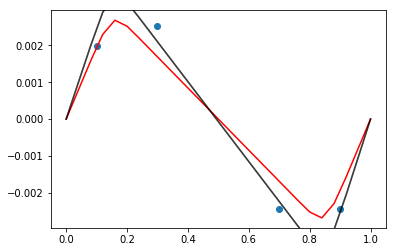

In [111]:
fe.plot(solve_heat_eq(zip(u_real[0,:], positions)),c='r')

for i in range(particles):
    fe.plot(solve_heat_eq(zip(u[i,:], positions)),c='black',alpha=0.25)

plt.scatter(measurement_points, y)

## Tests

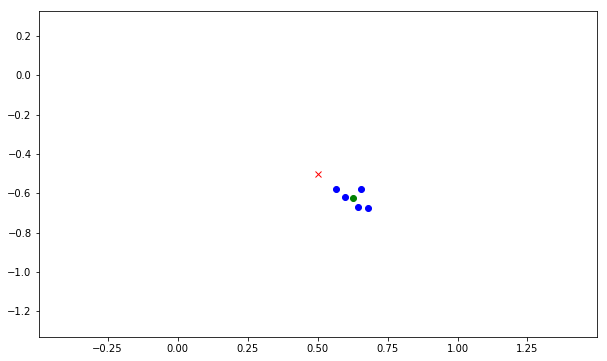

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))

u = path[0,:,:]
w = np.max(u[:,0]) - np.min(u[:,0])
h = np.max(u[:,1]) - np.min(u[:,1])

def init():
    plt_particles.set_data([], [])
    plt_truth.set_data(u_real[:,0], u_real[:,1])
    plt_mean.set_data([], [])
    plt_paths.set_data([], [])
    
    ax.set_xlim((u_real[0,0]-w, u_real[0,0]+w))
    ax.set_ylim((u_real[0,1]-h, u_real[0,1]+h))
    
    return plt_particles, plt_truth, plt_mean, plt_paths

def animate(i):
    u = path[i,:,:]
    u_bar = u.mean(axis=0).reshape((1,state_dims))
    
    plt_particles.set_data(u[:, 0], u[:, 1])
    plt_mean.set_data(u_bar[:, 0], u_bar[:, 1])

    return plt_particles, plt_truth, plt_mean, plt_paths

plt_particles, = ax.plot([], [], 'bo', ms=6)
plt_truth, = ax.plot([], [], 'rx', ms=6)
plt_mean, = ax.plot([], [], 'go', ms=6)
plt_paths, = ax.plot([], [], 'b--', lw=1)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=60, 
                               repeat_delay=1000, blit=True)
HTML(anim.to_html5_video())

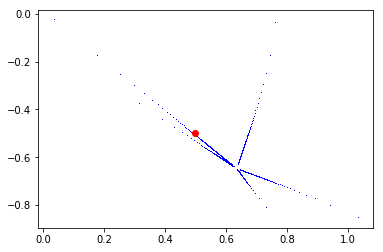

In [109]:
for i in range(0,int(t1/dt)):
    a = (int(t1/dt) - i)/int(t1/dt)
    plt.plot(path[i,:,0], path[i,:,1], 'b,')
    
#plt.plot(path[:,:,0], path[:,:,1], 'b--', lw=1)
plt.plot(u_real[:,0], u_real[:,1], 'ro')